# HW 1.
## Part 3. PixelCNN


In [1]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1hm077GxmIBP-foHxiPtTxSNy371yowk2' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1hm077GxmIBP-foHxiPtTxSNy371yowk2" -O mnist_hw1.pkl && rm -rf /tmp/cookies.txt

#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&confirm=8Qs8&id=1hm077GxmIBP-foHxiPtTxSNy371yowk2' -O mnist_hw1.pkl



--2019-12-23 15:43:30--  https://docs.google.com/uc?export=download&confirm=vLge&id=1hm077GxmIBP-foHxiPtTxSNy371yowk2
Resolving docs.google.com (docs.google.com)... 172.217.12.238, 2607:f8b0:4004:807::200e
Connecting to docs.google.com (docs.google.com)|172.217.12.238|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-4o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/l6qvsf5jg22o57noj85tva5r7ks8qrnj/1577109600000/01992697873098230653/*/1hm077GxmIBP-foHxiPtTxSNy371yowk2?e=download [following]
--2019-12-23 15:43:30--  https://doc-0k-4o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/l6qvsf5jg22o57noj85tva5r7ks8qrnj/1577109600000/01992697873098230653/*/1hm077GxmIBP-foHxiPtTxSNy371yowk2?e=download
Resolving doc-0k-4o-docs.googleusercontent.com (doc-0k-4o-docs.googleusercontent.com)... 172.217.164.129, 2607:f8b0:4004:814::2001
Connecting to doc-0k-4o-docs.googleusercontent.com (doc-0k

In [0]:
import pickle

with open('mnist_hw1.pkl', 'rb') as f:
    data_all = pickle.load(f)

In [3]:
data_all['train'][0].shape

(28, 28, 3)

In [0]:
import torch.utils.data as data

batch_size = 128

def collate_fn(xs):
    xs = torch.LongTensor(xs)
    xs = xs.permute(0, 3, 1, 2) #colour should be the first for our model
    return xs

train_data = data.DataLoader(
    dataset=data_all['train'],
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)
val_data = data.DataLoader(
    dataset=data_all['test'],
    batch_size=batch_size,
    shuffle=False,
    collate_fn=collate_fn
)


In [0]:
import torch.nn as nn

class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, channel_in, channel_out, kernel_size, stride, padding):
        super(MaskedConv2d, self).__init__(channel_in, channel_out, kernel_size, stride, padding, bias=False)
        self.mask_type = mask_type
        channel_out, channel_in, height, width = self.weight.size()

        mask = torch.ones(channel_out, channel_in, height, width)
        
        if mask_type == 'A':
            mask[:, :, height // 2, width // 2:] = 0
            mask[:, :, height // 2 + 1:] = 0
        else:
            mask[:, :, height // 2, width // 2 + 1:] = 0
            mask[:, :, height // 2 + 1] = 0
        
        self.register_buffer('mask', mask)


    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv2d, self).forward(x)

In [0]:
class MaskCNNBlock(nn.Module):
    def __init__(self, h=128):
        super(MaskCNNBlock, self).__init__()

        self.layers = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(2 * h, h, 1),
            nn.BatchNorm2d(h),
            nn.ReLU(),
            MaskedConv2d('B', h, h, 3, 1, 1),
            nn.BatchNorm2d(h),
            nn.ReLU(),
            nn.Conv2d(h, 2 * h, 1),
            nn.BatchNorm2d(2 * h)
        )

    def forward(self, x):
        x = self.layers(x) + x
        return x

In [0]:
class PixelCNN(nn.Module):
    def __init__(self, h=128):
        super(PixelCNN, self).__init__()

        layers = [MaskedConv2d('A', 3, 2 * h, 7, 1, 3)]
        layers += [MaskCNNBlock(h) for _ in range(12)] # in the task they ask for 12 such layers
        layers += [
            nn.ReLU(),
            nn.Conv2d(2 * h, 2 * h, 1),
            nn.BatchNorm2d(2 * h),
            nn.ReLU(),
            nn.Conv2d(2 * h, 3 * 4, 1)
        ]
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.float()
        n, c, h, w = x.shape
        x = self.layers(x)
        x = x.reshape(n, c, 4, h, w)
        x = x.permute(0, 1, 3, 4, 2)
        return x

In [0]:
import torch

device = torch.device("cuda")

In [0]:
def fit(model, train_data, val_data, optimizer, loss_function, epoch_cnt=5):
    train_losses = []
    val_losses = []

    for epoch in range(epoch_cnt):
        for idx, X in enumerate(train_data):
            X = X.to(device)
            optimizer.zero_grad()
            result = model(X)
            loss = loss_function(X, result)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()
            print('\rINFO: [Epoch %d/%d][idx %d/%d] Loss: %s'\
            % (epoch, epoch_cnt, idx, len(train_data), loss.item()), end="")
        with torch.no_grad():
            for X in val_data:
                X = X.to(device)
                result = model(X)
                loss = loss_function(X, result)
                val_losses.append(loss.item())
    return train_losses, val_losses

In [0]:
import torch.nn.functional as F

def count_loss(x, y):
    y = F.softmax(y, dim=-1)
    x = F.one_hot(x, 4).float()
    y = (x * y).sum(dim=-1)
    loss = -torch.log(y + 1e-9)
    loss = loss.mean()
    return loss

In [0]:
torch.cuda.empty_cache()

In [0]:
# when it was h=128, colab said that it tried to alloc too much. Sorry :(
model = PixelCNN(h=32)
model = model.float()
model = model.to(device)

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [92]:
train_losses, val_losses = fit(model, train_data, val_data, optimizer, count_loss, epoch_cnt=20)

INFO: [Epoch 19/20][idx 468/469] Loss: 0.09140090644359589

In [93]:
# The loss looks good, though. Let's draw the pictures
print(len(train_losses), len(val_losses))

9380 1580


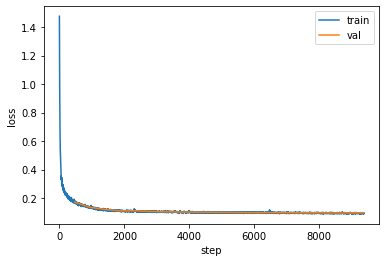

In [94]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(range(len(train_losses)), train_losses, label="train")
nval_losses = [np.mean(val_losses[i * 79: (i + 1) * 79]) for i in range(20)]
plt.plot(range(len(train_losses) // 20, len(train_losses) + 1, len(train_losses) // 20), nval_losses, label="val")
plt.xlabel('step')
plt.ylabel('loss')
plt.legend()
plt.show()

In [0]:
def draw_images(model, n=16):
    samples = np.zeros((n, 28, 28, 3), dtype=np.uint8)
    with torch.no_grad():
        for y in range(28):
            for x in range(28):
                for c in range(3):
                    ex = collate_fn(samples).to(device)
                    res = model(ex)
                    res = F.softmax(res, dim=4).cpu().numpy()
                    for i in range(n):
                        samples[i, y, x, c] = np.random.choice(4, p=res[i, c, y, x])
                        
    samples *= 85
    
    n = int(np.ceil(np.sqrt(n)))
    f, axarr = plt.subplots(n, n)
    f.set_figheight(15)
    f.set_figwidth(15)
    for i, img in enumerate(samples):
        axarr[i // n, i % n].imshow(img)
        axarr[i // n, i % n].axis('off')
    plt.show()

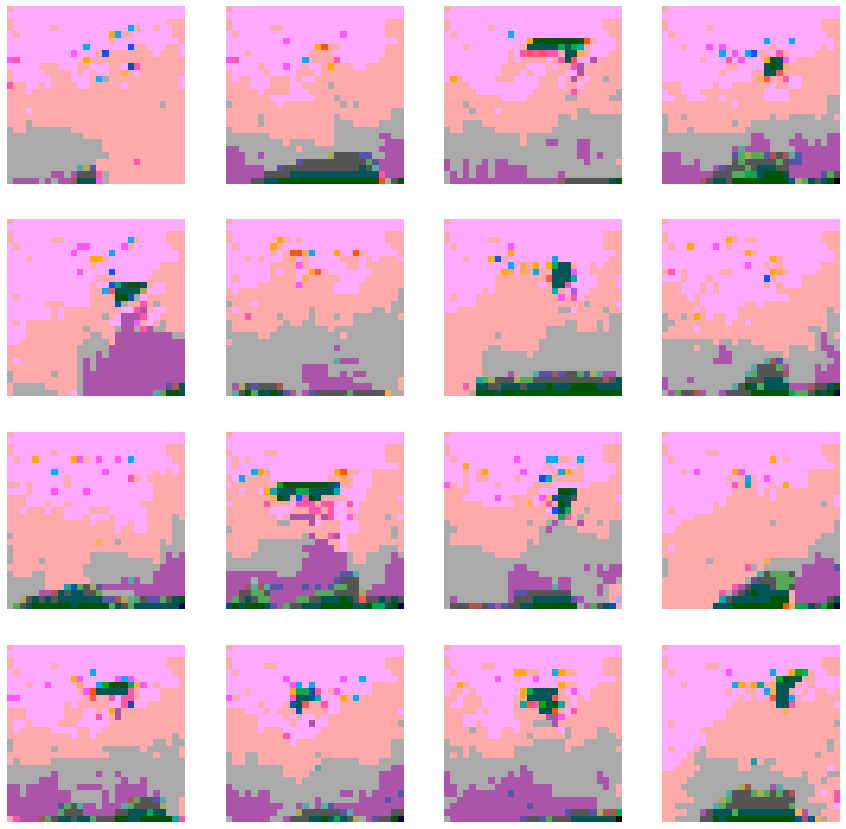

In [96]:
draw_images(model)

In [0]:
def receptive_field(model, X, loss_function):
    x = torch.tensor(X.numpy().astype(np.float32), requires_grad=True, device=device)
    res = model(x)[:, 0, 14, 14]
    
    loss = loss_function(X[:, 0, 14, 14].cpu(), res.cpu())
    loss.backward()
    
    img = x.grad.abs().sum(dim=(0, 1))
    img = img.cpu().float().numpy()
    
    plt.imshow(img)
    plt.show()

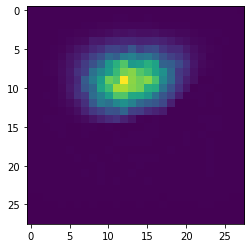

In [98]:
model2 = PixelCNN(h=32)
model2.to(device)
X = collate_fn(data_all['test'][:20])
receptive_field(model2, X, count_loss)

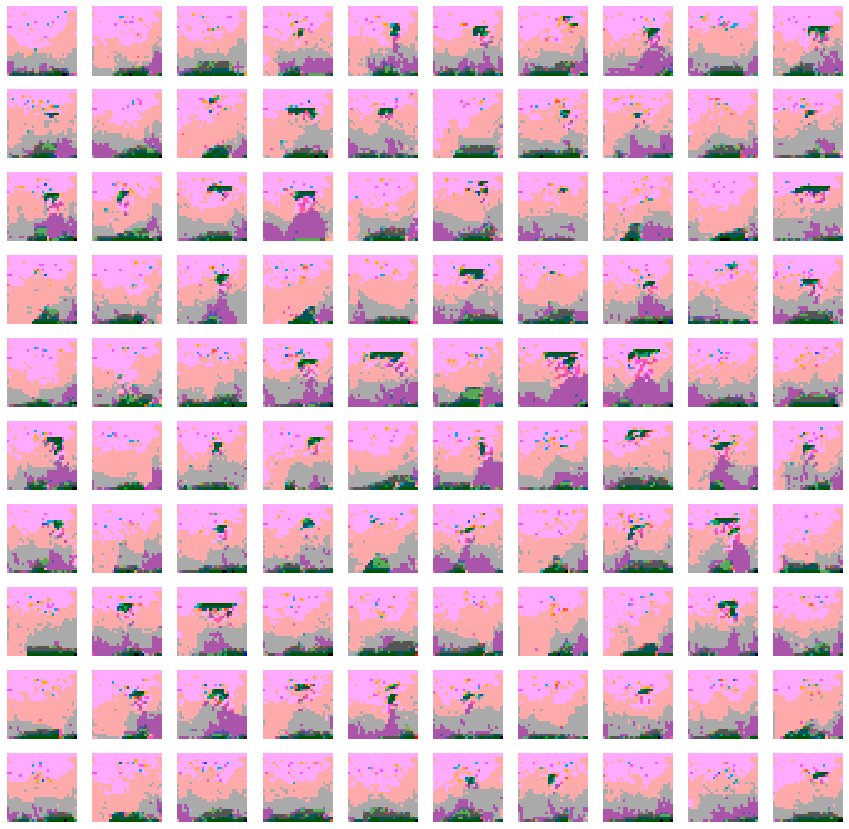

In [99]:
draw_images(model, n=100)